# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import os

# Reading Data

In [2]:
# Here, I separated environment folder with data folder, so I can work on smaller sample of data when developing and then resue the same code in production.

# folder where data exists
data_folder = './data'
# the environment folder 
env_folder = 'prod' 

file_path = os.path.join(data_folder, env_folder)

file_name = 'orders2.parquet'

In [3]:
# Reading the data from given environment as a datafframe 
df_orders = pd.read_parquet( os.path.join(file_path,  file_name))

In [4]:
# List to document what categorical columns can be encoded (I will use it for my own analysis)
lst_cat_col_low_freq = []
lst_cat_col_mid_freq = []

In [5]:
# I am not sure if the given data is correct but Origin_Country, Destination_Country and Site_Country are always the same in every row 
df_orders[
    (df_orders['Site_Country']!=df_orders['Origin_Country'])
    |
    (df_orders['Site_Country']!=df_orders['Destination_Country'])
    |
    (df_orders['Origin_Country']!=df_orders['Destination_Country'])
]

,order_id,PNR,order_created_at,booking_system,Site_Country,Brand,Order_Amount,currency,Revenue,Partner,...,Device,client_entry_type,booking_system_source_type,Origin_Country,Destination_Country,Journey_Type_ID,Is_Changed,Is_Canceled,cancel_reason,change_reason


# Exploring Orders

In [5]:
# Getting the head of order dataframe, and changing pandas option to show all columns
pd.set_option('display.max_columns', None)
df_orders.head(2)

,order_id,PNR,order_created_at,booking_system,Site_Country,Brand,Order_Amount,currency,Revenue,Partner,Customer_Group_Type,Device,client_entry_type,booking_system_source_type,Origin_Country,Destination_Country,Journey_Type_ID,Is_Changed,Is_Canceled,cancel_reason,change_reason
0,4607745402,VVNVMF,2024-01-01 00:00:01,System A,Italy,Brand A,824.68,Euro,9.09,Partner A,SINGLE,PC,b2bapi,GDS,Italy,Italy,One-way,0,0,Undefined,Initial - Not Changed
1,4607744269,8WJRXE,2024-01-01 00:00:04,System A,Australia,Brand A,1760.80,Australian Dollar,14.74,Partner B,SINGLE,iPhone,metasearch,GDS,Australia,Australia,Round-trip,1,0,Undefined,Schedule change: Primary Alternative


In [6]:
# Checking dataset to see if there is any null value
order_total_nulls = df_orders.isnull().sum(axis=0).sum()
print(f"The total number of null values in order data frame is: {order_total_nulls}")

The total number of null values in order data frame is: 0


In [7]:
# Getting more information about the order dataframe
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6300206 entries, 0 to 6300205
Data columns (total 21 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   order_id                    int64  
 1   PNR                         object 
 2   order_created_at            object 
 3   booking_system              object 
 4   Site_Country                object 
 5   Brand                       object 
 6   Order_Amount                float64
 7   currency                    object 
 8   Revenue                     float64
 9   Partner                     object 
 10  Customer_Group_Type         object 
 11  Device                      object 
 12  client_entry_type           object 
 13  booking_system_source_type  object 
 14  Origin_Country              object 
 15  Destination_Country         object 
 16  Journey_Type_ID             object 
 17  Is_Changed                  int64  
 18  Is_Canceled                 int64  
 19  cancel_reason        

In [8]:
# checking neumerical columns for order dataframe
df_orders.describe()

,order_id,Order_Amount,Revenue,Is_Changed,Is_Canceled
count,6.300206e+06,6.300206e+06,6.300206e+06,6.300206e+06,6.300206e+06
mean,4.611157e+09,6.025694e+04,2.506440e+03,5.628721e-02,3.903714e-02
std,6.162882e+06,1.144689e+06,6.824414e+04,2.304755e-01,1.936834e-01
min,4.600000e+09,-3.326000e+01,-3.160941e+06,0.000000e+00,0.000000e+00
25%,4.607827e+09,2.180200e+02,8.620000e+00,0.000000e+00,0.000000e+00
50%,4.611596e+09,5.479900e+02,1.522000e+01,0.000000e+00,0.000000e+00
75%,4.616405e+09,1.688990e+03,4.606000e+01,0.000000e+00,0.000000e+00
max,4.620000e+09,4.503267e+08,4.907213e+07,1.000000e+00,1.000000e+00


In [9]:
# Getting list of columns for order dataframe
print(
    'List of columns:', 
    ', '.join(list(df_orders.columns)) 
     )

List of columns: order_id, PNR, order_created_at, booking_system, Site_Country, Brand, Order_Amount, currency, Revenue, Partner, Customer_Group_Type, Device, client_entry_type, booking_system_source_type, Origin_Country, Destination_Country, Journey_Type_ID, Is_Changed, Is_Canceled, cancel_reason, change_reason


**Features description:**

Basic Order Information:
* **Order_id**:  A unique identifier for each booking order. It is numeric. 
* **PNR**: Passenger Name Record - a unique code used in the travel industry to identify a specific passenger or group of passengers linked to a booking, *an order might consist of **multiple** PNR*. 
    * Assumption 1. if a passanger has e.g. three PNR, does it mean that (s)he has three flights which were connecting??
* **Site_Country**: The country where the booking was made.
* **order_created_at**: The date and time when the booking was created.
* **Brand**: Indicates the specific brand associated with this booking. This could be one of our own brands or a partner brand.

Financial Details: 
* **Order_Amount**: The total price of the booking.
* **currency**:  The currency in which the Order_amount is expressed (e.g., USD, EUR, GBP).
* **Revenue**: The actual revenue generated from the booking (may differ from Order_amount due to discounts, fees, etc.)
* **Partner**: If the booking involved a third-party partner (like another travel agency, Meta, etc), this field might identify them.


Customer and Booking Context:

* **Customer_Group_Type**: Categorizes the customer (e.g., individual, family, group).
* **Device**: The type of device used to make the booking (e.g., desktop, mobile, tablet)
* **client_entry_type**: from which source the customer redirect to our platform (partner, Meta, our website and apps)
* **booking_system_source_type**: Not specified, I did some search and made this assumptions as the best possible one:
    * This may refers to the different sources or channels through which ticket bookings are made. 
* **booking_system**: The system we used to process the booking (e.g., Amadeus, Sabre).

Travel Details:

* **Origin_Country**:  The country where the journey starts.
* **Destination_Country**: The country where the journey ends.
* **Journey_Type_ID**: A code or identifier specifying the type of journey (e.g., one-way, round trip, multi-city).


Order Changes and Cancellations:
* **Is_Changed**: A boolean value (true/false) indicating whether the order has been modified after creation. 
* **Is_Canceled**: A boolean value (true/false) indicating whether the order has been cancelled.
* **cancel_reason**: The reason given for cancelling the order, if applicable.
* **change_reason**: The reason for any changes made to the order, if applicable.

## Basic Order Information

* **Order_id**:  A unique identifier for each booking order. It is numeric. 
* **PNR**: Passenger Name Record - a unique code used in the travel industry to identify a specific passenger or group of passengers linked to a booking, *an order might consist of **multiple** PNR*. 
    * Assumption 1. if a passanger has e.g. three PNR, does it mean that (s)he has three flights which were connecting??
* **Site_Country**: The country where the booking was made.
* **order_created_at**: The date and time when the booking was created.
* **Brand**: Indicates the specific brand associated with this booking. This could be one of our own brands or a partner brand.

In [10]:
# Checking if order_id is unique
print(
    'Checking if the order id is unique:', 
    len(df_orders['order_id'].unique()) == len(df_orders)
)

Checking if the order id is unique: True


In [11]:
# Checking the maximum and minimum number of PNRs for one order (separated by comma flattened in one field)
print(
    'The minimum and maximum numbers of PNR for one order are {0} and {1}.'.format( 
        df_orders['PNR'].str.count(',').min()+1, 
        df_orders['PNR'].str.count(',').max()+1
    )
)

The minimum and maximum numbers of PNR for one order are 1 and 8.


In [12]:
# Checking if the number of PNRs are the same as number of orders
len(df_orders['PNR'].unique())
len(df_orders)

6300206

# Feature Engineering

<b><font color='red'>Adding Feature: number_of_PNR</font></b>

In [13]:
# I add a column indicating number of PNRs for each order
df_orders['number_of_PNR'] = df_orders['PNR'].str.count(',') +1

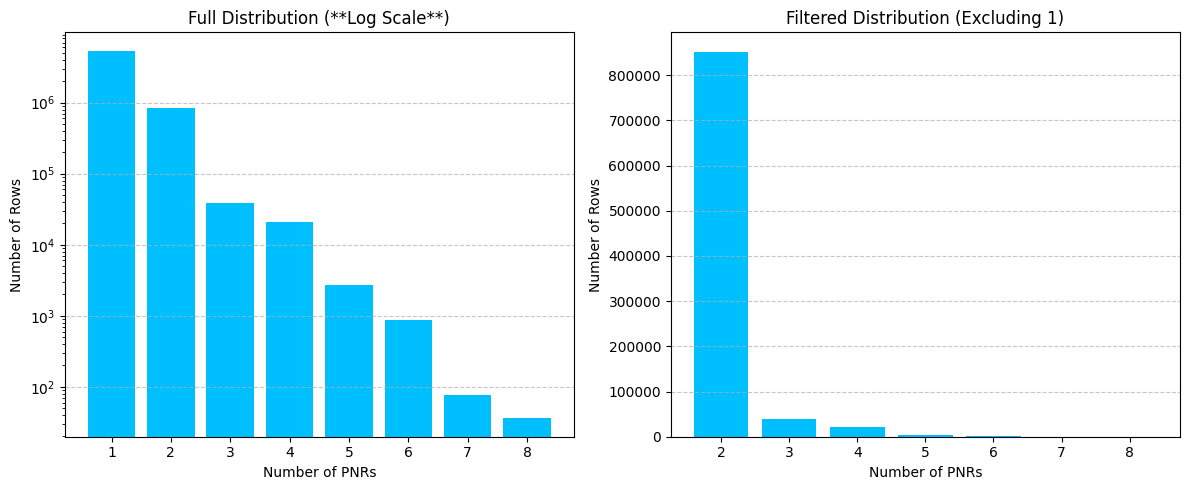

In [14]:
# bar plot showing distribution of PNRs
pnr_distribution = df_orders['number_of_PNR'].value_counts().sort_index()
filtered_distribution = pnr_distribution[pnr_distribution.index > 1]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(pnr_distribution.index, pnr_distribution.values, color = 'deepskyblue')
axes[0].set_title('Full Distribution (**Log Scale**)')
axes[0].set_xlabel('Number of PNRs')
axes[0].set_ylabel('Number of Rows')
axes[0].set_yscale('log')
axes[0].set_xticks(pnr_distribution.index)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)   

axes[1].bar(filtered_distribution.index, filtered_distribution.values, color = 'deepskyblue')
axes[1].set_title('Filtered Distribution (Excluding 1)')
axes[1].set_xlabel('Number of PNRs')
axes[1].set_ylabel('Number of Rows')
axes[1].set_xticks(filtered_distribution.index)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)    

plt.tight_layout()
plt.show()

In [15]:
# Checking from how many countries orders are made
print(
    'In total, we create order for {0} countries.'.format(
        len(df_orders['Site_Country'].unique())
    )
)

In total, we create order for 74 countries.


<b><font color='green'>Encodabale column: Site_Country</font></b>

In [16]:
# I append 'Site_Country' to the list of  middle frequencies columns
lst_cat_col_mid_freq.append('Site_Country')


In [17]:
# checking counts of each Site_Country in the order dataframe
df_orders['Site_Country'].value_counts()

Germany           738300
United Kingdom    693560
USA               566268
France            525612
Italy             311717
                   ...  
Uruguay             1180
Macau                654
Bolivia              361
Venezuela            247
Paraguay             157
Name: Site_Country, Length: 74, dtype: int64

Text(0, 0.5, 'Country')

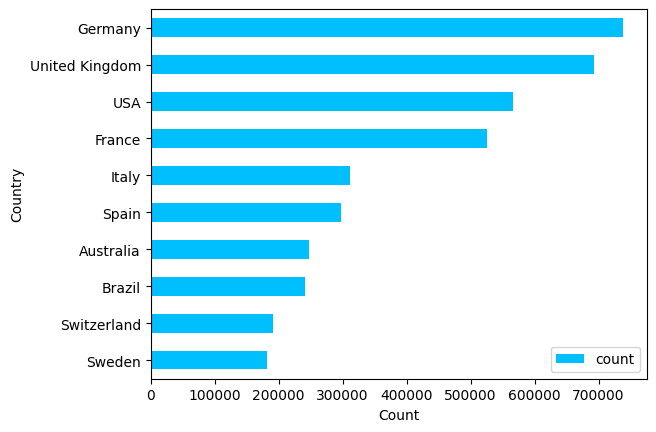

In [18]:
# basic plot showing top ten countries making orders 
df_orders['Site_Country'].value_counts().reset_index(name='count').rename(columns={'index': 'country'}).sort_values(by='count', ascending=False)[:10].sort_values(by='count').plot.barh(x='country', y='count', color = 'deepskyblue')  
plt.xlabel('Count')
plt.ylabel('Country')

In [19]:
# changing data type of order_created_at to datetime
df_orders['order_created_at'] = pd.to_datetime(df_orders['order_created_at'], errors='raise')

In [20]:
# Checking the time window of data
print(
    'The start and end date of orders are ', 
    df_orders['order_created_at'].min(), 
    ' and ',
    df_orders['order_created_at'].max(),
    ', meaning that the data is recorded over ',
    df_orders['order_created_at'].max() - df_orders['order_created_at'].min()
)

The start and end date of orders are  2024-01-01 00:00:01  and  2024-04-01 00:00:00 , meaning that the data is recorded over  90 days 23:59:59


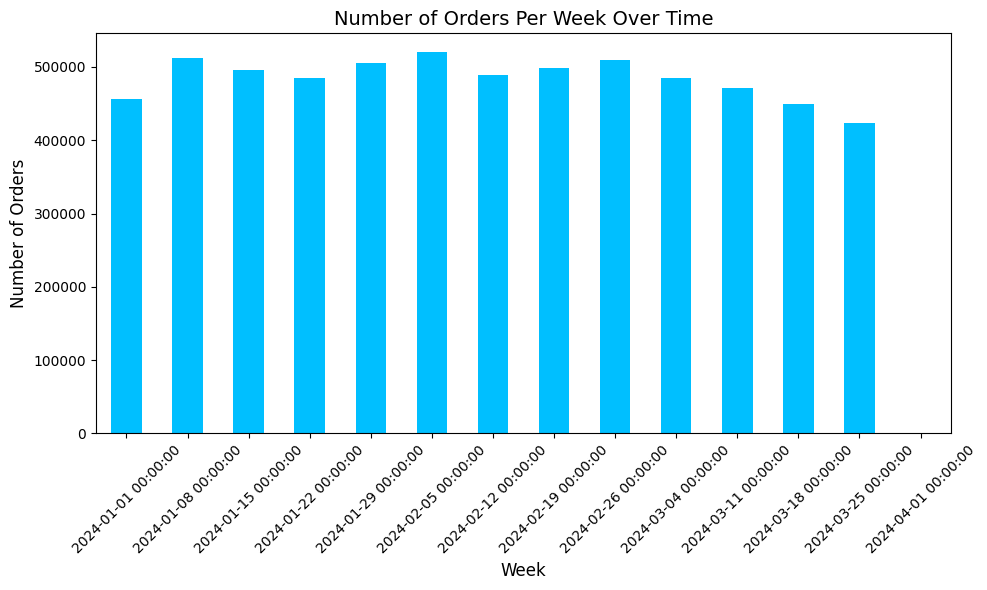

In [21]:
# Plot the data showing number of orders per week over a period of time

df_orders['week_start_day'] = df_orders['order_created_at'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_orders = df_orders.groupby('week_start_day')['order_id'].count()

plt.figure(figsize=(10, 6))
weekly_orders.plot(kind='bar', color = 'deepskyblue')
plt.title('Number of Orders Per Week Over Time', fontsize=14)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
# Checking count of values for each Brand
df_orders['Brand'].value_counts()

Brand A    3708873
Brand B    1133975
Brand D     840568
Brand C     214832
Brand E     190932
Brand F      97452
Brand G      60627
Brand H      50439
Brand J       1281
Brand K        964
Brand I        255
Brand M          5
Brand L          3
Name: Brand, dtype: int64

<b><font color='green'>Encodabale column: Brand</font></b>

In [23]:
# I append 'Brand' to the list of low frequencies columns
lst_cat_col_low_freq.append('Brand')

## Financial Details

* **Order_Amount**: The total price of the booking.
* **currency**:  The currency in which the Order_amount is expressed (e.g., USD, EUR, GBP).
* **Revenue**: The actual revenue generated from the booking (may differ from Order_amount due to discounts, fees, etc.)
* **Partner**: If the booking involved a third-party partner (like another travel agency, Meta, etc), this field might identify them.


In [24]:
# I check to see if the order amount is recorded in original currency. After checking we see that each order amount are recorded with a local currency, 
# meaning that they are not giving us a proper ground for comparison purposes. Therefore, we need to convert currency. Additionally, the data has also negative value
#  that shall be cleaned and investigated (in business scenario) 

df_orders[['Order_Amount', 'currency']].sort_values(by='Order_Amount', ascending=False)

,Order_Amount,currency
2544817,4.503267e+08,Vietnamese dong
4480153,2.416102e+08,Vietnamese dong
5215605,2.186191e+08,Vietnamese dong
1723931,2.038585e+08,Vietnamese dong
5265784,1.935117e+08,Rupiah Indonesia
...,...,...
2083654,-1.009000e+01,Euro
2222197,-1.039000e+01,Euro
628183,-1.289000e+01,Euro
866261,-1.339000e+01,Euro


In [25]:
# This statistics is  wrong becuase currencies are recorded in local currency
df_orders.groupby('currency')['Order_Amount'].sum().sort_values(ascending=False)[:5]

currency
Rupiah Indonesia           1.421399e+11
Vietnamese dong            6.847343e+10
South Korean Won           6.564555e+10
Colombian Peso Colombia    3.926035e+10
Uzbekistan Som             1.387001e+10
Name: Order_Amount, dtype: float64

In [26]:
# the same issue can be seen here as well:
df_orders.groupby('currency')['Revenue'].sum().sort_values(ascending=False)[:5]

currency
Rupiah Indonesia           5.811689e+09
South Korean Won           3.373244e+09
Vietnamese dong            2.836890e+09
Colombian Peso Colombia    1.231920e+09
Uzbekistan Som             6.019376e+08
Name: Revenue, dtype: float64

In [27]:
# This statistics is also wrong
df_orders.groupby('Site_Country')['Revenue'].sum().sort_values(ascending=False)[:5]

Site_Country
Indonesia     5.811807e+09
Korea         3.373244e+09
Vietnam       2.836890e+09
Colombia      1.231920e+09
Uzbekistan    6.019376e+08
Name: Revenue, dtype: float64

In [28]:
# This statistics is also wrong
df_orders.groupby('Site_Country')['Order_Amount'].sum().sort_values(ascending=False)[:5]

Site_Country
Indonesia     1.421453e+11
Vietnam       6.847343e+10
Korea         6.564555e+10
Colombia      3.926035e+10
Uzbekistan    1.387001e+10
Name: Order_Amount, dtype: float64

In [29]:
# I create a currency mapping (code)
currency_map = {
    'Euro': 'EUR',
    'Australian Dollar': 'AUD',
    'Brazilian Real': 'BRL',
    'US Dollar': 'USD',
    'Danish Krone': 'DKK',
    'Saudi Riyal': 'SAR',
    'Mexican Peso': 'MXN',
    'Pound Sterling': 'GBP',
    'Zloty': 'PLN',
    'Norwegian Krone': 'NOK',
    'Canadian Dollar': 'CAD',
    'United Arab Emirates dirham': 'AED',
    'Swedish Krona': 'SEK',
    'Chilean Peso': 'CLP',
    'Peso Uruguayo': 'UYU',
    'Nuevo Sol Peru': 'PEN',
    'South Korean Won': 'KRW',
    'Malaysian Ringgit': 'MYR',
    'Argentine Peso': 'ARS',
    'Thai Baht': 'THB',
    'Czech Koruna': 'CZK',
    'Colombian Peso Colombia': 'COP',
    'Kuwaiti Dinar': 'KWD',
    'Swiss Franc': 'CHF',
    'Hryvnia Ukraine': 'UAH',
    'South African Rand': 'ZAR',
    'Japanese yen': 'JPY',
    'Jordanian Dinar': 'JOD',
    'Bahraini Dinar': 'BHD',
    'New Zealand Dollar': 'NZD',
    'Indian Rupee': 'INR',
    'Egyptian Pound': 'EGP',
    'Bulgarian Lev': 'BGN',
    'Rupiah Indonesia': 'IDR',
    'Turkish Lira': 'TRY',
    'Qatari Rial': 'QAR',
    'Singapore Dollar': 'SGD',
    'Hong Kong Dollar': 'HKD',
    'Philippine Peso': 'PHP',
    'New Taiwan Dollar': 'TWD',
    'Rial Omani Oman': 'OMR',
    'Forint': 'HUF',
    'Yuan Renminbi': 'CNY',
    'Vietnamese dong': 'VND',
    'Iceland Krona': 'ISK',
    'Tenge Kazakhstan': 'KZT',
    'Uzbekistan Som': 'UZS'
}

<b><font color='red'>Adding Feature: currency_code, currency_to_use_conversion_rate, Order_Amount_in_USD, Revenue_in_USD</font></b>

In [30]:
# I add a column which record the currency code 
df_orders['currency_code'] = df_orders['currency'].map(currency_map)

In [31]:
# I got the exchange rate from https://console.fastforex.io/
# The analysis can be done in different ways, e.g. considering the value of exchange rate at the order date, etc.
# I assume the conversion will be done on analysis date meaning the money will be kept in original currency
# This assumption is also a simplistic assumption as I also do not have conversion rate per date so I can calculate the precise value of each order based on conversion date at time
# For read analysis, this might be needed to be done properly as I assume the value will be converted at the order date at some day close to order day. 

currency_map_conversion_to_usd = {
    "EUR": 0.97553,
    "AUD": 1.62632,
    "BRL": 6.09979,
    "USD": 1,
    "DKK": 7.28166,
    "SAR": 3.74721,
    "MXN": 20.718,
    "GBP": 0.81907,
    "PLN": 4.15897,
    "NOK": 11.47319,
    "CAD": 1.44195,
    "AED": 3.67173,
    "SEK": 11.21067,
    "CLP": 1011.61448,
    "UYU": 43.71647,
    "PEN": 3.76743,
    "KRW": 1471.63135,
    "MYR": 4.49439,
    "ARS": 1036.3751,
    "THB": 34.55553,
    "CZK": 24.47018,
    "COP": 4343.17588,
    "KWD": 0.30943,
    "CHF": 0.91612,
    "UAH": 42.39538,
    "ZAR": 19.08002,
    "JPY": 157.70954,
    "JOD": 0.70923,
    "NZD": 1.79926,
    "INR": 85.92338,
    "EGP": 50.56074,
    "IDR": 16161.81638,
    "TRY": 35.43218,
    "QAR": 3.63876,
    "SGD": 1.37008,
    "HKD": 7.7846,
    "PHP": 58.64648,
    "TWD": 33.12166,
    "OMR": 0.38399,
    "HUF": 403.16982,
    "CNY": 7.33091,
    "VND": 25351.26015,
    "ISK": 140.85053,
    "KZT": 526.65433,
    "BGN": 1.89875,
    "BHD": 0.37598,
    "UZS": 13065.38673
  }

In [32]:
# I add a column recording the conversion rate 
df_orders['currency_to_use_conversion_rate'] = df_orders['currency_code'].map(currency_map_conversion_to_usd)

In [33]:
# Feature Engineering for Amount and Revenue in which we calculate the order amount and revenue in USD after converting the currency
df_orders['Order_Amount_in_USD'] = df_orders['Order_Amount'] / df_orders['currency_to_use_conversion_rate']
df_orders['Revenue_in_USD'] = df_orders['Revenue'] / df_orders['currency_to_use_conversion_rate']

In [34]:
# top five paid currencies
df_orders.groupby('currency')['Order_Amount_in_USD'].sum().sort_values(ascending=False)[:5]

currency
Euro                 1.416497e+09
US Dollar            4.631414e+08
Pound Sterling       4.626368e+08
Australian Dollar    1.757195e+08
Swiss Franc          1.342048e+08
Name: Order_Amount_in_USD, dtype: float64

In [35]:
# top five revenues
df_orders.groupby('currency')['Revenue_in_USD'].sum().sort_values(ascending=False)[:5]

currency
Euro                 4.662558e+07
Pound Sterling       1.500542e+07
US Dollar            1.240143e+07
Swedish Krona        6.761179e+06
Australian Dollar    5.469884e+06
Name: Revenue_in_USD, dtype: float64

In [36]:
# top five country with the highest order amount
df_orders.groupby('Site_Country')['Order_Amount_in_USD'].sum().sort_values(ascending=False)[:5]

Site_Country
United Kingdom    4.626368e+08
Germany           4.497059e+08
USA               3.989076e+08
France            3.170599e+08
Australia         1.757195e+08
Name: Order_Amount_in_USD, dtype: float64

In [37]:
# top five country with the highest revenue 
df_orders.groupby('Site_Country')['Revenue_in_USD'].sum().sort_values(ascending=False)[:5]

Site_Country
United Kingdom    1.500542e+07
Germany           1.297295e+07
France            1.042283e+07
USA               9.685541e+06
Sweden            6.761179e+06
Name: Revenue_in_USD, dtype: float64

In [38]:
# Getting columns of order dataframe
df_orders.columns

Index(['order_id', 'PNR', 'order_created_at', 'booking_system', 'Site_Country',
       'Brand', 'Order_Amount', 'currency', 'Revenue', 'Partner',
       'Customer_Group_Type', 'Device', 'client_entry_type',
       'booking_system_source_type', 'Origin_Country', 'Destination_Country',
       'Journey_Type_ID', 'Is_Changed', 'Is_Canceled', 'cancel_reason',
       'change_reason', 'number_of_PNR', 'week_start_day', 'currency_code',
       'currency_to_use_conversion_rate', 'Order_Amount_in_USD',
       'Revenue_in_USD'],
      dtype='object')

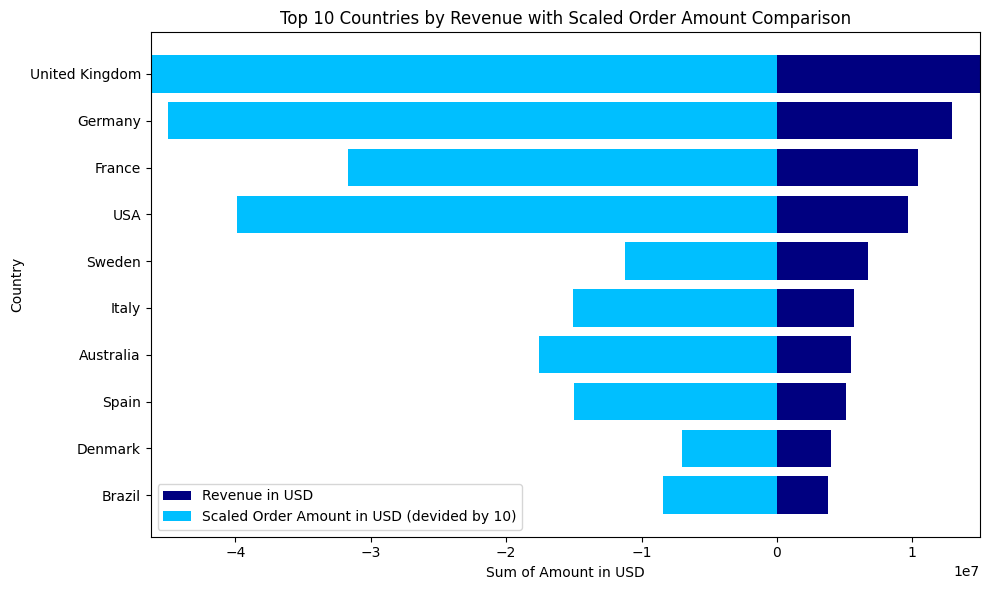

In [39]:
# Visualizing top ten countries by comparing revenue with scaled order amount in USD
country_revenue_order_totals = df_orders.groupby('Site_Country')[['Order_Amount_in_USD', 'Revenue_in_USD']].sum()
top_10_countries_by_revenue = country_revenue_order_totals.sort_values(by='Revenue_in_USD', ascending = False).head(10).sort_values(by='Revenue_in_USD')

fig, ax = plt.subplots(figsize=(10, 6))

max_order_amount = top_10_countries_by_revenue['Order_Amount_in_USD'].max()
max_revenue = top_10_countries_by_revenue['Revenue_in_USD'].max()

scale_factor_order = max_order_amount / max_revenue

ax.barh(top_10_countries_by_revenue.index, top_10_countries_by_revenue['Revenue_in_USD'], color='navy', label='Revenue in USD')
#ax.barh(top_10_countries_by_revenue.index, -top_10_countries_by_revenue['Order_Amount_in_USD'] / scale_factor_order, color='r', label='Scaled Order Amount in USD')
ax.barh(top_10_countries_by_revenue.index, -top_10_countries_by_revenue['Order_Amount_in_USD']/ 10, color='deepskyblue', label='Scaled Order Amount in USD (devided by 10)')

#ax.set_xlim([-max_order_amount / scale_factor_order, max_revenue])
ax.set_xlim([-max_order_amount /10, max_revenue])


ax.set_title('Top 10 Countries by Revenue with Scaled Order Amount Comparison')
ax.set_xlabel('Sum of Amount in USD')
ax.set_ylabel('Country')
ax.legend()
plt.tight_layout()
plt.show()

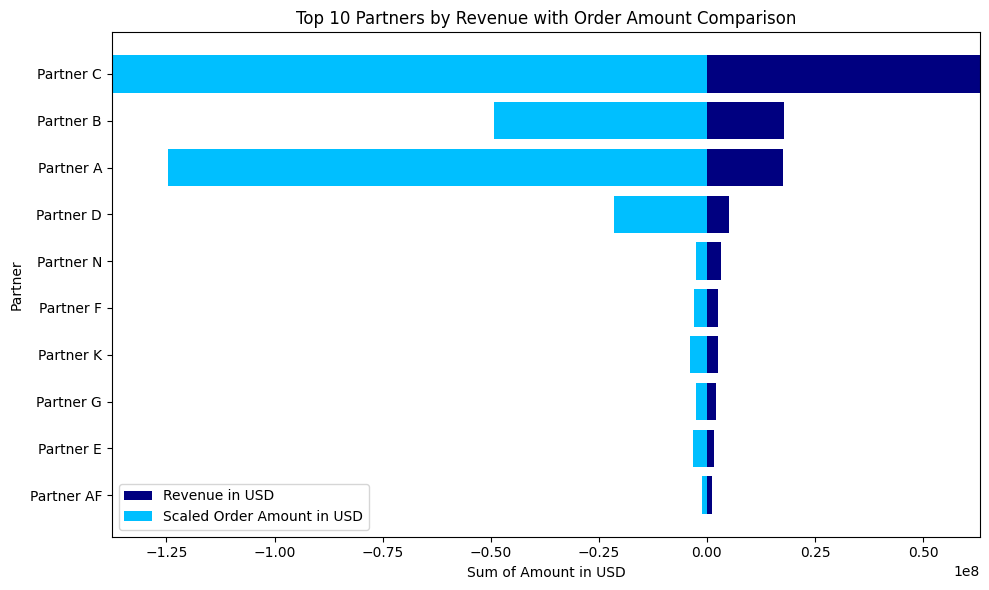

In [40]:
# Visualizing top ten partners by comparing revenue with scaled order amount in USD
partner_revenue_order_totals = df_orders.groupby('Partner')[['Order_Amount_in_USD', 'Revenue_in_USD']].sum()
top_10_partners_by_revenue = partner_revenue_order_totals.sort_values(by='Revenue_in_USD', ascending = False).head(10).sort_values(by='Revenue_in_USD')

fig, ax = plt.subplots(figsize=(10, 6))

max_order_amount = top_10_partners_by_revenue['Order_Amount_in_USD'].max()
max_revenue = top_10_partners_by_revenue['Revenue_in_USD'].max()

scale_factor_order = max_order_amount / max_revenue

ax.barh(top_10_partners_by_revenue.index, top_10_partners_by_revenue['Revenue_in_USD'], color='navy', label='Revenue in USD')
#ax.barh(top_10_partners_by_revenue.index, -top_10_partners_by_revenue['Order_Amount_in_USD'] / scale_factor_order, color='r', label='Scaled Order Amount in USD')
ax.barh(top_10_partners_by_revenue.index, -top_10_partners_by_revenue['Order_Amount_in_USD'] / 10, color='deepskyblue', label='Scaled Order Amount in USD')

#ax.set_xlim([-max_order_amount / scale_factor_order, max_revenue])
ax.set_xlim([-max_order_amount / 10, max_revenue])

ax.set_title('Top 10 Partners by Revenue with Order Amount Comparison')
ax.set_xlabel('Sum of Amount in USD')
ax.set_ylabel('Partner')
ax.legend()

plt.tight_layout()
plt.show()

## Customer and Booking Context
* **Customer_Group_Type**: Categorizes the customer (e.g., individual, family, group).
* **Device**: The type of device used to make the booking (e.g., desktop, mobile, tablet)
* **client_entry_type**: from which source the customer redirect to our platform (partner, Meta, our website and apps)
* **booking_system_source_type**: Not specified, I did some search and made this assumptions as the best possible one:
    * This may refers to the different sources or channels through which ticket bookings are made. 
* **booking_system**: The system we used to process the booking (e.g., Amadeus, Sabre).

In [41]:
# Checking the number of unique values for Customer Group type
df_orders['Customer_Group_Type'].value_counts()

SINGLE    3645294
COUPLE    1655721
FAMILY     637471
GROUP      361720
Name: Customer_Group_Type, dtype: int64

Text(0.5, 1.0, 'Distribution of group type')

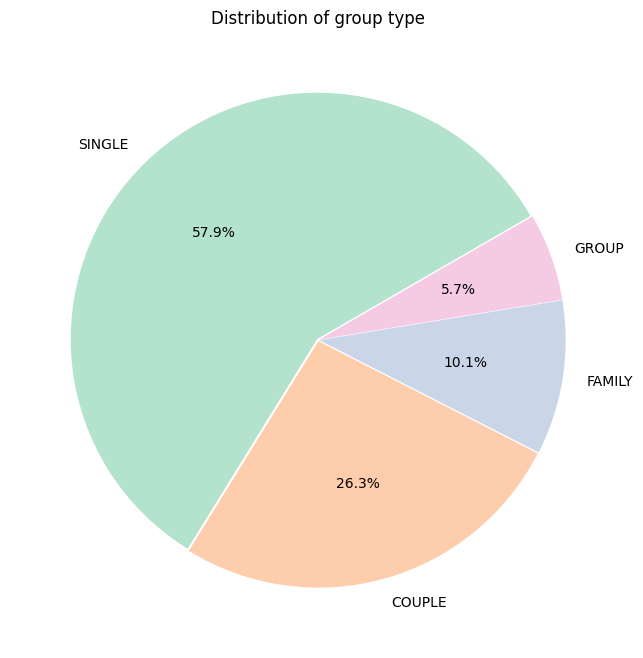

In [42]:
# pie chart showing percentage of each customer per group type
plt.figure(figsize = (10, 8))

explode = []

for i in range (len(df_orders['Customer_Group_Type'].unique())):
    explode.append(0.005)
    

plt.pie(df_orders['Customer_Group_Type'].value_counts(), labels = df_orders['Customer_Group_Type'].value_counts().index , startangle = -330, autopct='%1.1f%%', colors=plt.cm.Pastel2.colors, explode = tuple(explode))

plt.title('Distribution of group type', fontsize = 12)

<b><font color='green'>Encodabale column: Customer_Group_Type</font></b>

In [43]:
# I append 'Customer_Group_Type' to the list of low frequencies columns
lst_cat_col_low_freq.append('Customer_Group_Type')

In [44]:
# Getting count of values for Device
df_orders['Device'].value_counts()

PC                2853489
iPhone            2165298
Android Phone     1110813
iPad                67115
Android Tablet      53784
Unknown             46641
AnonPhone            2991
BlackBerry             49
AnonTablet             12
iPod                   12
Application             2
Name: Device, dtype: int64

<b><font color='green'>Encodabale column: Device</font></b>

In [45]:
# I append 'Device' to the list of low frequencies columns
lst_cat_col_low_freq.append('Device')

In [46]:
# Checking the number of unique values for client_entry_type
df_orders['client_entry_type'].value_counts()

metasearch        4048493
b2bapi            1977370
sponsoredlinks     106889
app                 67788
undefined           47599
organic             25224
affiliate           15975
email               10400
newsletter            404
internal               50
competition            12
coupon                  2
Name: client_entry_type, dtype: int64

<b><font color='green'>Encodabale column: client_entry_type</font></b>

In [47]:
# I append 'client_entry_type' to the list of low frequencies columns
lst_cat_col_low_freq.append('client_entry_type')

In [48]:
# Checking the number of unique values for booking_system_source_type
df_orders['booking_system_source_type'].value_counts()

GDS             3259014
API             1564873
NDC              994168
Web scrape       450204
Ticketless        27418
Consolidator       3562
LCC                 967
Name: booking_system_source_type, dtype: int64

<b><font color='green'>Encodabale column: booking_system_source_type</font></b>

In [49]:
# I append 'booking_system_source_type' to the list of low frequencies columns
lst_cat_col_low_freq.append('booking_system_source_type')

I did some search to udnerstand these values, I found this information (needs to be confirmed - for now, I use them as hypothesis):

* GDS (Global Distribution System): computerized networks that can be used to book airline tickets, etc.
* API (Application Programming Interface): how we can connect with service providers (e.g., airlines) to retrieve real-time data and make bookings.
* NDC reported as a newer standard developed by the International Air Transport Association (IATA) to enable airlines to distribute their services in a more personalized and flexible way, allowing agents to access richer content and customized offers.
* Web Scrape: this might mean gathering pricing and availability data from competitors or service providers, which can then be used for ticket bookings.
* Ticketless: refers to bookings where the traveler does not receive a physical or electronic ticket but is instead issued a booking reference that allows them to check in or board. This might be common for certain types of low-cost carriers (LCCs) or specific types of services.
* Consolidator: companies that purchase large blocks of airline tickets at discounted rates and resell them to travel agents, often at a markup. These agencies usually work with multiple airlines and offer discounted fares.
* LCC (Low-Cost Carrier): LCC refers to budget airlines that offer lower ticket prices by cutting down on amenities and services. Examples include Ryanair, EasyJet, and Southwest Airlines.

In [50]:
# (booking_system): Checking the maximum and minimum number of booking_system (separated by comma flattened in one field)
print(
    'The minimum and maximum numbers of booking_system for one order are {0} and {1}.'.format( 
        df_orders['booking_system'].str.count(',').min()+1, 
        df_orders['booking_system'].str.count(',').max()+1
    )
)

The minimum and maximum numbers of booking_system for one order are 1 and 5.


<b><font color='red'>Adding Feature: number_of_booking_system</font></b>

In [51]:
# I add a column indicating number of booking systems for each order
df_orders['number_of_booking_system'] = df_orders['booking_system'].str.count(',') +1

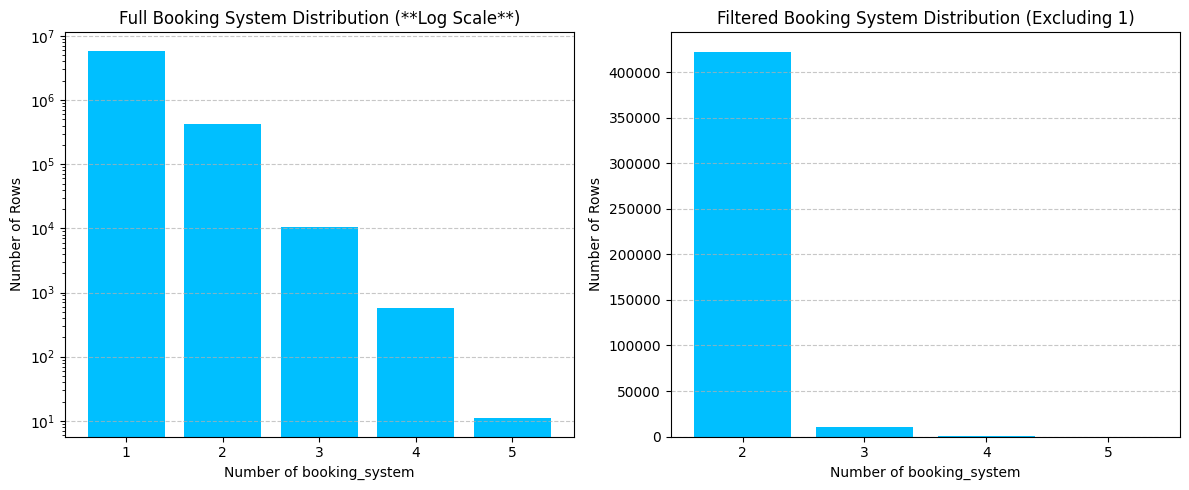

In [52]:
# Visualizing distribution of booking systems
booking_system_distribution = df_orders['number_of_booking_system'].value_counts().sort_index()
filtered_booking_system_distribution = booking_system_distribution[booking_system_distribution.index > 1]


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(booking_system_distribution.index, booking_system_distribution.values, color = 'deepskyblue')
axes[0].set_title('Full Booking System Distribution (**Log Scale**)')
axes[0].set_xlabel('Number of booking_system')
axes[0].set_ylabel('Number of Rows')
axes[0].set_yscale('log')
axes[0].set_xticks(booking_system_distribution.index)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)    


axes[1].bar(filtered_booking_system_distribution.index, filtered_booking_system_distribution.values, color = 'deepskyblue')
axes[1].set_title('Filtered Booking System Distribution (Excluding 1)')
axes[1].set_xlabel('Number of booking_system')
axes[1].set_ylabel('Number of Rows')
axes[1].set_xticks(filtered_booking_system_distribution.index)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)    

plt.tight_layout()
plt.show()

## Travel Details:

* **Origin_Country**:  The country where the journey starts.
* **Destination_Country**: The country where the journey ends.
* **Journey_Type_ID**: A code or identifier specifying the type of journey (e.g., one-way, round trip, multi-city).

In [53]:
# checking value counts of for each origin country
df_orders['Origin_Country'].value_counts()

Germany           738300
United Kingdom    693560
USA               566268
France            525612
Italy             311717
                   ...  
Uruguay             1180
Macau                654
Bolivia              361
Venezuela            247
Paraguay             157
Name: Origin_Country, Length: 74, dtype: int64

In [54]:
# checking value counts for each destination country
df_orders['Destination_Country'].value_counts()

Germany           738300
United Kingdom    693560
USA               566268
France            525612
Italy             311717
                   ...  
Uruguay             1180
Macau                654
Bolivia              361
Venezuela            247
Paraguay             157
Name: Destination_Country, Length: 74, dtype: int64

In [55]:
# I am not sure if the given data is correct but Origin_Country, Destination_Country and Site_Country are always the same in every row 
df_orders[
    (df_orders['Site_Country']!=df_orders['Origin_Country'])
    |
    (df_orders['Site_Country']!=df_orders['Destination_Country'])
    |
    (df_orders['Origin_Country']!=df_orders['Destination_Country'])
]

,order_id,PNR,order_created_at,booking_system,Site_Country,Brand,Order_Amount,currency,Revenue,Partner,Customer_Group_Type,Device,client_entry_type,booking_system_source_type,Origin_Country,Destination_Country,Journey_Type_ID,Is_Changed,Is_Canceled,cancel_reason,change_reason,number_of_PNR,week_start_day,currency_code,currency_to_use_conversion_rate,Order_Amount_in_USD,Revenue_in_USD,number_of_booking_system


In [56]:
# checking value counts for each journey type id
df_orders['Journey_Type_ID'].value_counts()

One-way                     3829653
Round-trip                  2347358
OpenJawSingleOrigin           66131
MultiStop                     29376
OpenJawSingleDestination      24990
OpenJawDouble                  2698
Name: Journey_Type_ID, dtype: int64

<b><font color='green'>Encodabale column: booking_system_source_type</font></b>

In [57]:
# I append 'Journey_Type_ID' to the list of low frequencies columns
lst_cat_col_low_freq.append('Journey_Type_ID')

Searching for conext:
    
* One-way: a ticket where the traveler is flying from one location to another without a return trip.
* Round-trip: a ticket that includes both the outbound and return ticket. 
* OpenJawSingleOrigin: involves traveling from one location to another but returning from a different location,
* MultiStop: involves more than two destinations. It could include multiple layovers or stopovers at different locations.
* OpenJawSingleDestination: similar to the "OpenJawSingleOrigin," but with the difference being the traveler starts at one location and returns to a different destination. The "single destination" suggests that only one destination is involved in the return trip.
* OpenJawDouble: involves both the outbound and return trips originating and ending in different locations. This type of journey is typically used for more complex travel arrangements, such as multi-country travel.

## Order Changes and Cancellations:
* **Is_Changed**: A boolean value (true/false) indicating whether the order has been modified after creation. 
* **Is_Canceled**: A boolean value (true/false) indicating whether the order has been cancelled.
* **cancel_reason**: The reason given for cancelling the order, if applicable.
* **change_reason**: The reason for any changes made to the order, if applicable.

In [58]:
print(
    'The percentage of orders which are chanegd over all the orders are {0:.2f}%.'.format(
        100 * df_orders['Is_Changed'].sum() / df_orders['Is_Changed'].count()
    )
)

The percentage of orders which are chanegd over all the orders are 5.63%.


In [59]:
print(
    'The percentage of orders which are canceled over all the ordersare {0:.2f}%.'.format(
        100 * df_orders['Is_Canceled'].sum() / df_orders['Is_Canceled'].count()
    )
)

The percentage of orders which are canceled over all the ordersare 3.90%.


In [60]:
# checking value counts for each cancel_reason
df_orders['cancel_reason'].value_counts()

Undefined                                6054263
Void                                       68123
Ticket rules - airline fee                 44460
Schedule Change - refund                   42460
Tech error - ticket                        15507
Ticket rules - taxes                       15135
Ticket rules - no refund to customer        9401
Orphan funds                                9252
24h airline rule                            5067
Force Majeure - No ETG claim                5026
Cancellation Guarantee                      4367
Force Majeure - refund                      3973
24H BR Cancellation                         3737
CXL before ticketing                        3213
Fraud                                       2648
GDPR Waiver                                 2640
Schedule change - no ETG claim              2447
Failed Flex Rebooking                       1740
Cancellation protection XCover              1620
Connection Guarantee                        1579
Dupe                

Text(0.5, 1.0, 'Count of Cancellation per Reason')

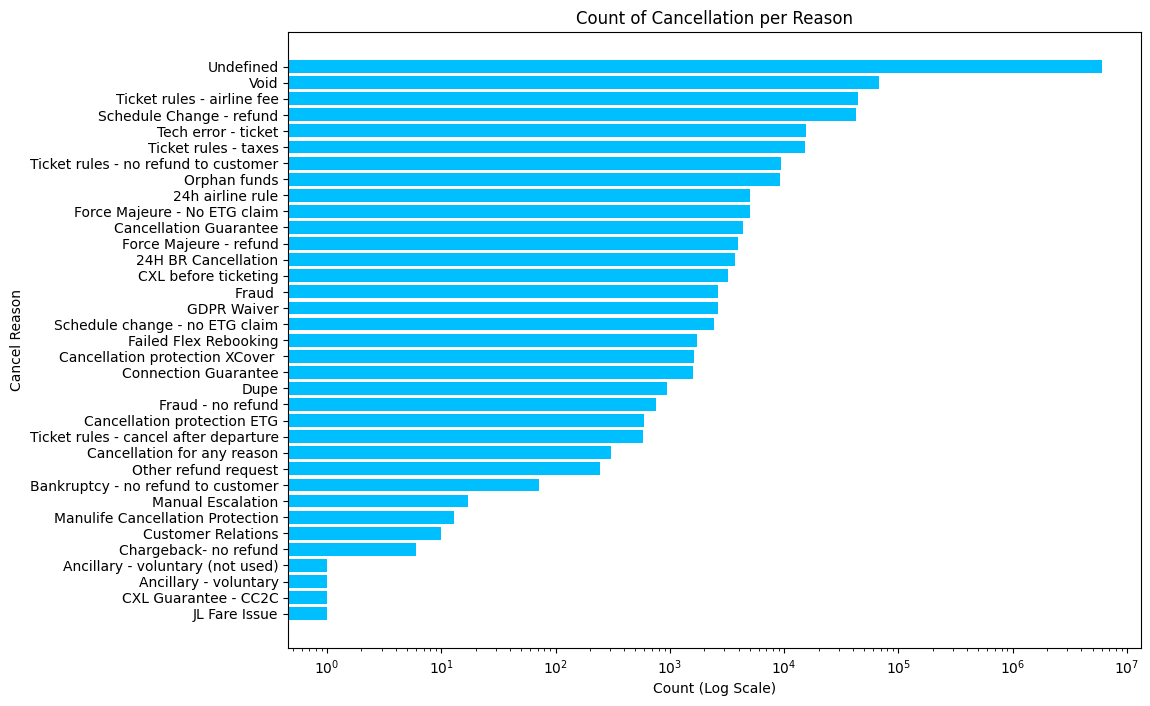

In [61]:
# Bar chart showing count of cancellation reason for each reason
plt.figure(figsize=(11,8))

cancel_reason_grouped = df_orders['cancel_reason'].value_counts().reset_index(name='count').rename(columns={'index': 'cancel_reason'}).sort_values(by='count', ascending=False).sort_values(by='count')

plt.barh(cancel_reason_grouped['cancel_reason'], cancel_reason_grouped['count'], color = 'deepskyblue')  

plt.xscale('log')
plt.xlabel('Count (Log Scale)')
plt.ylabel('Cancel Reason')
plt.title('Count of Cancellation per Reason')

<b><font color='green'>Encodabale column: cancel_reason</font></b>

In [62]:
# I append 'cancel_reason' to the list of middle frequency columns
lst_cat_col_mid_freq.append('cancel_reason')

In [63]:
# Checking the number of unique values for change_reason
df_orders['change_reason'].value_counts()

Initial - Not Changed                     5945576
Schedule change: Primary Alternative       175483
Cancel part of order                        90771
Against Ticket Rules - change               47855
Flexible ticket                             19234
Connection guarantee                         9215
Namechange or  namecorrection - change       5198
Schedule change: Secondary Alternative       3145
New ticket                                   1871
LCC cancellation voucher                     1337
Force Majeure - change                        302
Rebooked before ticketing                      82
Split PNR                                      60
COVID-19 Open ticket/voucher                   54
Infant booked                                  19
Bankruptcy - change                             3
Optimization                                    1
Name: change_reason, dtype: int64

Text(0.5, 1.0, 'count of change reason for each Reason')

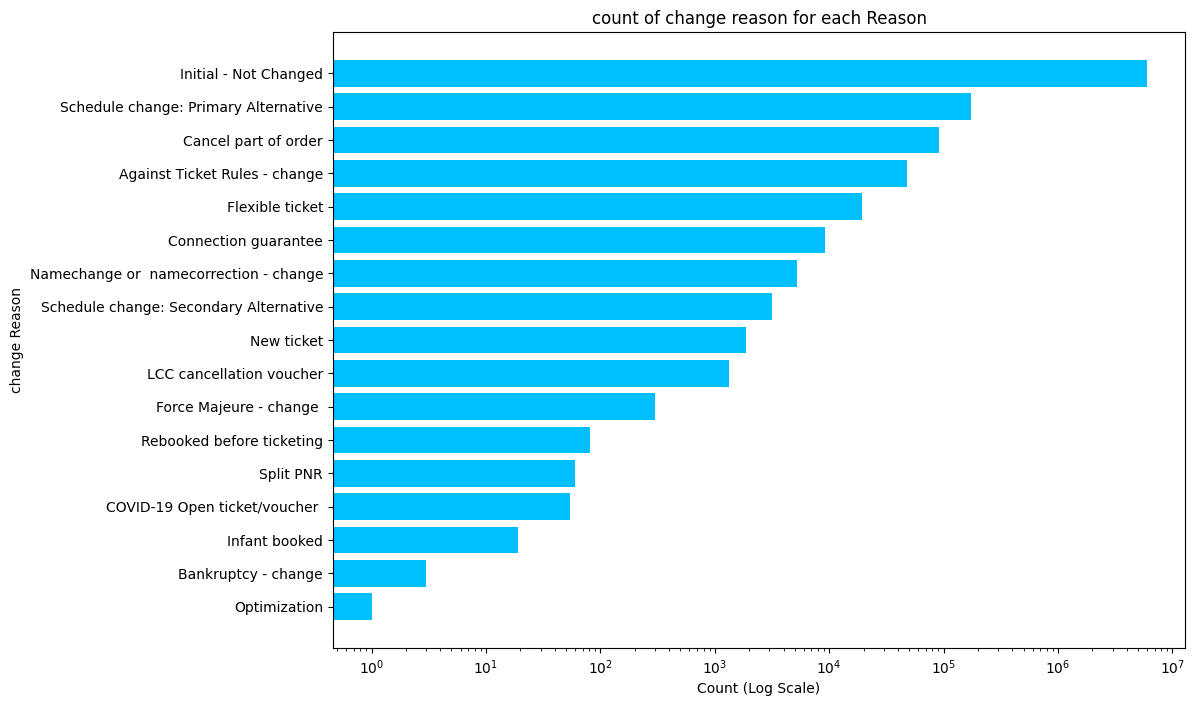

In [64]:
# Bar chart showing count of change reason for each reason
plt.figure(figsize=(11,8))

change_reason_grouped = df_orders['change_reason'].value_counts().reset_index(name='count').rename(columns={'index': 'change_reason'}).sort_values(by='count', ascending=False).sort_values(by='count')

plt.barh(change_reason_grouped['change_reason'], change_reason_grouped['count'], color = 'deepskyblue')  

plt.xscale('log')
plt.xlabel('Count (Log Scale)')
plt.ylabel('change Reason')
plt.title('count of change reason for each Reason')



<b><font color='green'>Encodabale column: change_reason</font></b>

In [65]:
# I append 'change_reason' to the list of middle frequency columns
lst_cat_col_low_freq.append('change_reason')

## Export Data for Further plot

In [66]:
# I export Site_country to a csv for plotting map for further analysis
df_orders.groupby('Site_Country').agg(
    order_count=('order_id', 'count'),
    total_order_amount_in_usd=('Order_Amount_in_USD', 'sum'),
    total_revenue_in_usd=('Revenue_in_USD', 'sum')
).reset_index().rename(columns={'Site_Country': 'country'}).to_csv(os.path.join(file_path, 'Sales_Sum_Per_Country.csv'))


In [67]:
# list of feature with mid range frequencies (maybe hard for one hot encoding considering the size of data)
lst_cat_col_mid_freq

['Site_Country', 'cancel_reason']

In [68]:
# list of feature with low range frequencies (good candidates for one hot encoding considering the size of data)
lst_cat_col_low_freq

['Brand',
 'Customer_Group_Type',
 'Device',
 'client_entry_type',
 'booking_system_source_type',
 'Journey_Type_ID',
 'change_reason']

In [69]:
# Here are list of numeric columsn in this data set that I document here for upcoming notebooks
selected_numeric_columns = [
    'order_id', 'Is_Changed', 'Is_Canceled', 'number_of_PNR', 'number_of_booking_system', 
    'Order_Amount_in_USD', 'Revenue_in_USD'
]

In [70]:
# Here are list of categorical columsn in this data set that I document here for upcoming notebooks
selected_categorical_columns = [
    'Site_Country', 'cancel_reason', 'Brand', 'Customer_Group_Type', 'Device', 
    'client_entry_type', 'booking_system_source_type', 'Journey_Type_ID', 'change_reason'
]

In [71]:
# saving the transformed data for upcoming notebooks
df_orders.to_parquet(os.path.join(file_path, 'cleaned_orders.parquet'))